This notebook has code for training and evaluating MC dropout models. It also contains code for visualisation of  outputs of all four different models. Make sure to run the notebook *uncertainty_adv.ipynb* before this.

In [1]:
# Author : Sumanth Hegde

import os
# optionally set gpu device id 
# os.environ['CUDA_VISIBLE_DEVICES']='2'

In [ ]:

#import necessary libraries
import pickle
import tensorflow as tf
from keras import layers
import keras 
import keras.backend as K
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage as nd

%matplotlib inline
import pylab as pl

from IPython import display

from tensorflow.examples.tutorials.mnist import input_data
import utilities as U
from utilities import fgm

In [3]:
## Fix seed to improve reproducibility
tf.set_random_seed(1234)
np.random.seed(1331) 

In [4]:
# Download MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

num_classes= 10 # number of classes

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
kernel_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_in", distribution="truncated_normal", seed=1234
)
lmb = 0.005
bias_init = kernel_init
def get_keras_model(): # LeNet model in keras. LeNet variant used is as mentioned in the Evidential Deep Learning paper
    model = keras.Sequential()
    model.add(layers.Reshape((28,28,1), input_shape=(784,)))
    model.add(layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1), kernel_initializer=kernel_init, bias_initializer=bias_init))
    model.add(layers.MaxPool2D(strides=(2,2)))
    model.add(layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
    model.add(layers.MaxPool2D(strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(500, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init, kernel_regularizer=keras.regularizers.l2(lmb)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=10, activation = 'softmax', kernel_initializer=kernel_init, bias_initializer=bias_init, kernel_regularizer=keras.regularizers.l2(lmb)))
    return model

In [6]:
# set config parameters of the session
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
K.set_session(session)

# build the model
keras_model = get_keras_model()
keras_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 50)          25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)             

In [7]:
bsize=1000

keras_model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
keras_model.fit(mnist.train.images, mnist.train.labels,epochs=50, batch_size=bsize) # same parameters as EDL


Epoch 1/50
55000/55000 [==============================] - 4s 73us/step - loss: 4.5966 - accuracy: 0.7244
Epoch 2/50
55000/55000 [==============================] - 1s 12us/step - loss: 2.1128 - accuracy: 0.9442
Epoch 3/50
55000/55000 [==============================] - 1s 11us/step - loss: 1.2825 - accuracy: 0.9635
Epoch 4/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.8521 - accuracy: 0.9694
Epoch 5/50
55000/55000 [==============================] - 1s 11us/step - loss: 0.6019 - accuracy: 0.9741
Epoch 6/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.4451 - accuracy: 0.9759
Epoch 7/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.3449 - accuracy: 0.9774
Epoch 8/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.2776 - accuracy: 0.9788
Epoch 9/50
55000/55000 [==============================] - 1s 11us/step - loss: 0.2323 - accuracy: 0.9792
Epoch 10/50
55000/55000 [=============================

In [8]:
keras_model.save_weights('keras_model_mc.h5')

In [9]:
# load saved weights if any
keras_model.load_weights('keras_model_mc.h5') 

In [11]:
loss_ce = tf.keras.losses.categorical_crossentropy

n_mc= 30
BATCH = 100 # evaluated in batches of 100 since graph may not fit one GPU for entire test set. Change batch size if needed


with tf.get_default_graph().as_default():
    mc_model = U.MCModel(keras_model, keras_model._layers_by_depth[9][0].input, n_mc)
    x_input = K.placeholder(shape=(None,784))
    mc_preds = U.mc_dropout_preds(mc_model, x_input, n_mc)
    y_preds = K.mean(mc_preds,axis=0)
    pred_entropy_t = U.predictive_entropy(mc_preds)
x_test = mnist.test.images
y_test = mnist.test.labels
all_accs = []
all_ents = []
for eps in np.linspace(0,1,11):
    attack_params = {'eps':eps, 
                  'clip_min':None, 
                  'clip_max':None}
    x_adv_tensor = fgm(x_input, y_preds, loss_fn=loss_ce, **attack_params)
    func_eval = K.function([x_input],[y_preds, pred_entropy_t])
    batch_size = BATCH
    nbatches = len(x_test)//batch_size
    accs = []
    ents = []
    for i in range(nbatches): 
        x_batch  = x_test[i*batch_size:(i+1)*batch_size]
        labels = y_test[i*batch_size:(i+1)*batch_size]
        x_adv = x_adv_tensor.eval(session=K.get_session(),feed_dict={x_input:x_batch})
        x_adv = x_adv/np.max(x_adv,1,keepdims=True) # preprocessing
        
        y_pred_adv, ent_adv = func_eval([x_adv])
        labels_ = np.argmax(labels, axis=1)
        y_ = np.argmax(y_pred_adv, axis=1)
        acc = sum(y_==labels_)*1.0/batch_size
        accs.append(acc)
        if (i+1)%10==0:
            print(f'{i+1} batches done')
        ents.append(np.mean(ent_adv))

    print('Accuracy : {}, Entropy : {}, eps : {} '.format(np.mean(accs), np.mean(ents), eps))
    all_accs.append(np.mean(accs))
    all_ents.append(np.mean(ents))

10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
80 batches done
90 batches done
100 batches done
Accuracy : 0.9904, Entropy : 0.039667144417762756, eps : 0.0 
10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
80 batches done
90 batches done
100 batches done
Accuracy : 0.7194000000000002, Entropy : 0.48324307799339294, eps : 0.1 
10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
80 batches done
90 batches done
100 batches done
Accuracy : 0.16450000000000004, Entropy : 0.9196449518203735, eps : 0.2 
10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
80 batches done
90 batches done
100 batches done
Accuracy : 0.022499999999999996, Entropy : 0.9817104935646057, eps : 0.30000000000000004 
10 batches done
20 batches done
30 batches done
40 batches

In [12]:
with open('./results/accuracies_mc.pkl','wb') as f:
    pickle.dump(all_accs,f)
with open('./results/entropies_mc.pkl','wb') as f:
    pickle.dump(all_ents,f)

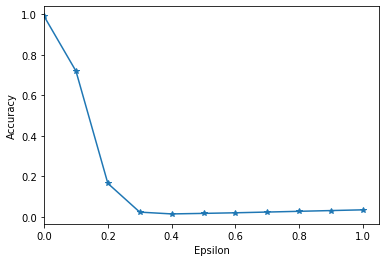

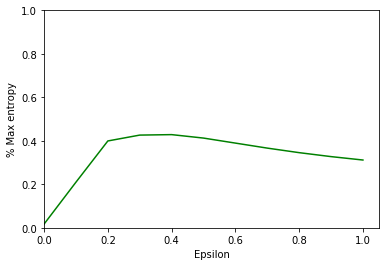

In [13]:
plt.plot(np.linspace(0,1,11),all_accs,'-*')
plt.xlabel('Epsilon')
plt.xlim(left=0)
plt.ylabel('Accuracy')
plt.show()
plt.plot(np.linspace(0,1,11),np.array(all_ents)/np.log(10),'g')
plt.xlabel('Epsilon')
plt.ylabel('% Max entropy')
plt.xlim(left=0)
plt.ylim(0,1)
plt.show()

## Concrete Dropout 

In [14]:
from keras.layers import Input, Dense, Lambda, Concatenate, Layer
from keras.models import Model
from keras import initializers
from keras.engine import InputSpec
# from keras.datasets import mnist
from keras import layers
class ConcreteDropout(Layer):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(**kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)
        self.layer = layer

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build(input_shape=None)  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        input_dim = np.prod(input_shape[-1])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer) # Eq 3 of the paper.

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

In [15]:
D = 1 # One mean and one var
l = 1e-4 # length scale
num_classes = 10


In [16]:
kernel_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_in", distribution="truncated_normal", seed=None
)
lmb = 0.005
bias_init = kernel_init
def get_concrete_model(X):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp  = Input(shape=(784,))
    x = layers.Reshape((28,28,1), input_shape=(784,))(inp)
    x = layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1), kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    x = layers.MaxPool2D(strides=(2,2))(x)
    x = layers.Conv2D(filters=50, kernel_size=(5, 5), activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    x = layers.MaxPool2D(strides=(2,2))(x)
    x = layers.Flatten()(x)
    x = ConcreteDropout(Dense(500, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = layers.Dense(units=10, activation = 'softmax', kernel_initializer=kernel_init, bias_initializer=bias_init, kernel_regularizer=keras.regularizers.l2(lmb))(x)
    model = Model(inputs=inp,outputs=x)
    model.summary()
    return model, X

In [17]:
K.clear_session()

In [18]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)
model, x_train = get_concrete_model(mnist.train.images)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 50)          25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0   

In [19]:
# for epoch in range(epochs)
bsize=1000
# y_train = Y_train

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.fit(x_train, mnist.train.labels ,epochs=50, batch_size=bsize)


Epoch 1/50
55000/55000 [==============================] - 1s 24us/step - loss: 0.6078 - accuracy: 0.8453
Epoch 2/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.1821 - accuracy: 0.9652
Epoch 3/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.1320 - accuracy: 0.9778
Epoch 4/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.1078 - accuracy: 0.9819
Epoch 5/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.0912 - accuracy: 0.9848
Epoch 6/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.0778 - accuracy: 0.9867
Epoch 7/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.0670 - accuracy: 0.9885
Epoch 8/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.0593 - accuracy: 0.9898
Epoch 9/50
55000/55000 [==============================] - 1s 12us/step - loss: 0.0525 - accuracy: 0.9908
Epoch 10/50
55000/55000 [==============================

In [20]:
model.save_weights('concrete_model.h5')

In [21]:
# load concrete model if weights saved previously
model.load_weights('concrete_model.h5')

In [22]:
model.layers[0].input

<tf.Tensor 'input_1:0' shape=(?, 784) dtype=float32>

In [24]:

loss_ce = tf.keras.losses.categorical_crossentropy

n_mc= 30
BATCH = 100 # evaluated in batches of 100 since graph may not fit one GPU for entire test set. Change batch size if needed
with tf.get_default_graph().as_default():
    mc_model = U.MCModel(model, model.layers[0].input, n_mc)
    x_input = K.placeholder(shape=(None,784))
    mc_preds = U.mc_dropout_preds(mc_model, x_input, n_mc)
    y_preds = K.mean(mc_preds,axis=0)
    pred_entropy_t = U.predictive_entropy(mc_preds)
    
all_accs = []
all_ents = []
x_test = mnist.test.images
y_test  = mnist.test.labels
for eps in np.linspace(0,1,11):
    attack_params = {'eps':eps, 
                  'clip_min':None, 
                  'clip_max':None}
    x_adv_tensor = fgm(x_input, y_preds, loss_fn=loss_ce, **attack_params)
    func_eval = K.function([x_input],[y_preds, pred_entropy_t])
    batch_size = BATCH
    nbatches = len(x_test)//batch_size
    accs = []
    ents = []
    for i in range(nbatches): 
        x_batch  = x_test[i*batch_size:(i+1)*batch_size]
        labels = y_test[i*batch_size:(i+1)*batch_size]
        x_adv = x_adv_tensor.eval(session=K.get_session(),feed_dict={x_input:x_batch})
        x_adv = x_adv/np.max(x_adv,1,keepdims=True) # preprocessing
        
        y_pred_adv, ent_adv = func_eval([x_adv])
        labels_ = np.argmax(labels, axis=1)
        y_ = np.argmax(y_pred_adv, axis=1)
        acc = sum(y_==labels_)*1.0/batch_size
        accs.append(acc)
        if (i+1)%10==0:
            print(f'{i+1} batches done')
        ents.append(np.mean(ent_adv))

    print('Accuracy : {}, Entropy : {}, eps : {} '.format(np.mean(accs), np.mean(ents), eps))
    all_accs.append(np.mean(accs))
    all_ents.append(np.mean(ents))

10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
80 batches done
90 batches done
100 batches done
Accuracy : 0.9933000000000001, Entropy : 0.024983488023281097, eps : 0.0 
10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
80 batches done
90 batches done
100 batches done
Accuracy : 0.6635000000000001, Entropy : 0.375810444355011, eps : 0.1 
10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
80 batches done
90 batches done
100 batches done
Accuracy : 0.193, Entropy : 0.3820151090621948, eps : 0.2 
10 batches done
20 batches done
30 batches done
40 batches done
50 batches done
60 batches done
70 batches done
80 batches done
90 batches done
100 batches done
Accuracy : 0.15220000000000003, Entropy : 0.3648725748062134, eps : 0.30000000000000004 
10 batches done
20 batches done
30 batches done
40 batches done

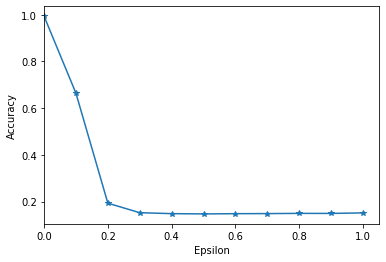

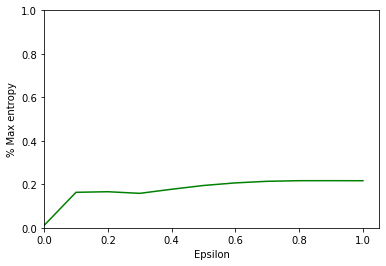

In [25]:
plt.plot(np.linspace(0,1,11),all_accs,'-*')
plt.xlabel('Epsilon')
plt.xlim(left=0)
plt.ylabel('Accuracy')
plt.show()
plt.plot(np.linspace(0,1,11),np.array(all_ents)/np.log(10),'g')
plt.xlabel('Epsilon')
plt.ylabel('% Max entropy')
plt.xlim(left=0)
plt.ylim(0,1)
plt.show()

In [26]:
with open('./results/accuracies_concrete_mc.pkl','wb') as f:
    pickle.dump(all_accs,f)
with open('./results/entropies_concrete_mc.pkl','wb') as f:
    pickle.dump(all_ents,f)

## Visualise results

Run the below code blocks once the results have been saved for all the four models

In [27]:
with open('./results/accuracies_edl.pkl','rb') as f:
    accs_edl = pickle.load(f)
with open('./results/accuracies_mc.pkl','rb') as f:
    accs_mc = pickle.load(f)
with open('./results/accuracies_concrete_mc.pkl','rb') as f:
    accs_mc_con = pickle.load(f)
with open('./results/accuracies_l2.pkl','rb') as f:
    accs_l2 = pickle.load(f)


with open('./results/entropies_l2.pkl','rb') as f:
    ents_l2 = pickle.load(f)
with open('./results/entropies_edl.pkl','rb') as f:
    ents_edl = pickle.load(f)
with open('./results/entropies_mc.pkl','rb') as f:
    ents_mc = pickle.load(f)
with open('./results/entropies_concrete_mc.pkl','rb') as f:
    ents_mc_con = pickle.load(f)  

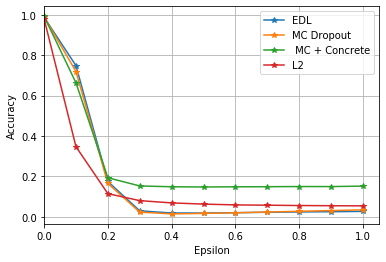

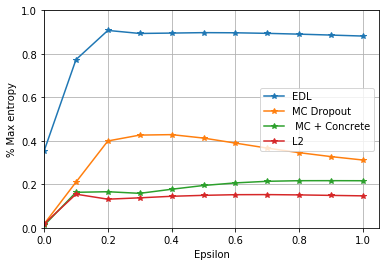

In [28]:

plt.plot(np.linspace(0,1,11),accs_edl,'-*',label='EDL')
plt.plot(np.linspace(0,1,11),accs_mc,'-*',  label='MC Dropout')
plt.plot(np.linspace(0,1,11),accs_mc_con,'-*', label=' MC + Concrete')
plt.plot(np.linspace(0,1,11),accs_l2,'-*', label='L2')
plt.xlabel('Epsilon')
plt.xlim(left=0)
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
plt.plot(np.linspace(0,1,11),np.array(ents_edl)/np.log(10),'-*',label='EDL')
plt.plot(np.linspace(0,1,11),np.array(ents_mc)/np.log(10),'-*', label='MC Dropout')
plt.plot(np.linspace(0,1,11),np.array(ents_mc_con)/np.log(10),'-*', label=' MC + Concrete')
plt.plot(np.linspace(0,1,11),np.array(ents_l2)/np.log(10),'-*', label='L2')
plt.xlabel('Epsilon')
plt.ylabel('% Max entropy')
plt.xlim(left=0)
plt.ylim(0,1)
plt.legend(loc='center right')
plt.grid(True)
plt.show()